In [2]:
import numpy as np
from numpy.random import normal, uniform
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# Equations from Bishop:


Prior considering zero-mean and isotropic Gaussian governed by a single precision parameter $\alpha$:
$$ p(\vec{w} \mid \alpha) = Norm(\vec{w} \mid \vec{0}, \alpha^{-1}\vec{I}) \tag{3.52}$$

corresponding posterior dist over w is given by
$$p(\vec{w} \mid \vec{t}) =  Norm(\vec{w} \mid \vec{m}_N, \vec{S}_N) \tag{3.49}$$
where

$$ \vec{m}_N = \vec{S}_N(\vec{S}_0^{-1}\vec{m}_0 + \beta\vec{\Phi}^T\vec{t}) \tag{3.50}$$
$$ \vec{S}^{-1}_N = \vec{S}_0^{-1} + \beta\vec{\Phi}^T\vec{\Phi} \tag{3.51}$$
<!-- $$ \vec{m}_N = \beta\vec{S}_N\vec{\Phi}^T\vec{t} \tag{3.53}$$
$$ \vec{S}^{-1}_N = \alpha\vec{I} + \beta\vec{\Phi}^T\vec{\Phi} \tag{3.54}$$ -->

Note: $\Phi$ is an N x M matrix (design matrix) whose elements are given by $\Phi_{nj} = \phi_{j}(x_n)$.

Also, likelihood is given by:

$$ p(\bold{t} \mid \bold{X}, \vec{w}, \beta) =\prod_{n=1}^{N} Norm(t_n \mid \vec{w}^T \vec{\phi}(\vec{x_n}), \beta^{-1})  \tag{3.10}$$


In [82]:
class LinearBayes(object):
    """
    A class that holds parameter prior/posterior and handles 
    the hyper-parameter updates with new data
    
    Note:  variables starting with "v_" indicate Nx1 dimensional 
        column vectors, those starting with "m_" indicate 
        matrices, and those starting with "a_" indicate 
        1xN dimensional arrays.
    
    Args:
        a_m0 (np.array): prior mean vector of size 1xM where M is the number of features
        m_S0 (np.ndarray): prior covariance matrix of size MxM
        beta (float): known real-data noise precision
        
    """
    def __init__(self, m0, S0, beta):
        self.prior = multivariate_normal(mean=m0, cov=S0)
        self.m0 = m0.reshape(m0.shape + (1,)) #reshape to column vector
        self.S0 = S0
        self.beta = beta
        
        self.mN = self.m0
        self.SN = self.S0
        self.posterior = self.prior
           
    def get_phi(self, a_x):
        """
        Returns the design matrix of size (NxM) for a feature vector v_x.
        In this case, this function merely adds the phi_0 dummy basis
        that's equal to 1 for all elements.
        
        Args:
            a_x (np.array): input features of size 1xN
        """
        phi = np.ones((len(a_x), 2))
        phi[:, 1] = a_x
        return phi
        
    def set_posterior(self, a_x, a_t):
        """
        Updates mN and SN given vectors of x-values and t-values
        """
        # Need to convert v_t from an array into a column vector
        # to correctly compute matrix multiplication
        v_t = a_t.reshape(a_t.shape + (1,))

        phi = self.get_phi(a_x)
        
        # Equations 3.50 and 3.51
        self.SN = np.linalg.inv(np.linalg.inv(self.S0) + self.beta*phi.T.dot(phi))
        self.mN = self.SN.dot(np.linalg.inv(self.S0).dot(self.m0) + \
                                      self.beta*phi.T.dot(v_t))
        
        # Equation 3.49
        self.posterior = multivariate_normal(mean=self.mN.flatten(), cov=self.SN)

    def set_likelihood(self, a_x, a_t, grid_x, grid_y):
        """
        Computes the likelihood values for a grid of parameters.
        """
        # X, Y = np.meshgrid(grid_x, grid_y)
        pos = np.empty(grid_x.shape + (2,))
        pos[:, :, 0] = grid_x
        pos[:, :, 1] = grid_y

        phi = self.get_phi(a_x)
        v_t = a_t.reshape(a_t.shape + (1,))
        likelihood = np.zeros(grid_x.shape)

        for i in range(grid_x.shape[0]):
            for j in range(grid_x.shape[1]):
                w = np.array([grid_x[i, j], grid_y[i, j]])
                mean = phi.dot(w)
                likelihood[i, j] = multivariate_normal(mean=mean, cov=(1/self.beta) * np.eye(len(mean))).pdf(v_t.flatten())
        
        self.likelihood = likelihood

    def predict(self, a_x):
        N = len(a_x)
        m_x = self.get_phi(a_x).T.reshape((2, 1, N))
        
        predictions = []
        for idx in range(N):
            x = m_x[:,:,idx]
            sig_sq_x = 1/self.beta + x.T.dot(self.m_SN.dot(x))
            mean_x = self.v_mN.T.dot(x)
            predictions.append(normal(mean_x.flatten(), np.sqrt(sig_sq_x)))
        return np.array(predictions)
    
    def make_contour(self, a_x, a_y, real_parms=[], N=0):
        """
        A helper function to generate contour plots of our probability distribution
        """
        pos = np.empty(a_x.shape + (2,))
        pos[:, :, 0] = a_x
        pos[:, :, 1] = a_y

        plt.contourf(a_x, a_y, self.posterior.pdf(pos), 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
            
        _ = plt.title('Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
    
    def make_likelihood_contour(self, grid_x, grid_y, real_parms=[], N=0):
        """
        Plots the contour of the likelihood function.
        """
        if self.likelihood is None:
            raise ValueError("Likelihood not set. Call set_likelihood() first.")
        
        pos = np.empty(grid_x.shape + (2,))
        pos[:, :, 0] = grid_x
        pos[:, :, 1] = grid_y
        
        plt.contourf(grid_x, grid_y, self.likelihood, 20)
        plt.xlabel('$w_0$', fontsize=16)
        plt.ylabel('$w_1$', fontsize=16)
        
        if real_parms:
            plt.scatter(real_parms[0], real_parms[1], marker='+', c='black', s=60)
        
        _ = plt.title('Likelihood Distribution for Weight Parameters using %d datapoint(s)' % N, fontsize=10)
        plt.show()
    
    def make_scatter(self, a_x, a_t, real_parms, samples=None):
        """
        A helper function to plot noisey data, the true function, 
        and optionally a set of lines specified by the nested array of
        weights of size NxM where N is number of lines, M is 2 for 
        this simple model
        """
        plt.scatter(a_x, a_t, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('t')

        y = generate_data(real_parms[0], real_parms[1], 0, np.array([-1.,1.]))

        plt.plot([-1, 1], y)

        _ = plt.title('Real Data from Noisey Linear Function')
        
        if samples:
            weights = self.posterior.rvs(samples)
            for weight in weights: 
                plt.plot([-1, 1], y, 'black')
                _ = plt.title('Lines Sampled from Posterior Distribution vs Real Line and Data')

In [83]:
def generate_data(a_0, a_1, noise_sigma, X):
    N = len(X)
    noise = np.random.normal(0, noise_sigma, N)
    y = a_0 + a_1 * X + noise
    return y

In [84]:
a_0 = -0.3
a_1 = 0.5   
noise_sigma = 0.2
beta = 1/noise_sigma**2

size = 20
X = np.random.uniform(-1, 1, 20)

y = generate_data(a_0, a_1, noise_sigma, X)

In [85]:
alpha = 2.0
m0 = np.array([0, 0])
S0 = (1/alpha) * np.eye(2)

linbayes = LinearBayes(m0, S0, beta)

In [86]:
real_parms = [a_0, a_1]
generate_data(real_parms[0], real_parms[1], 0, np.array([-1.,1.]))

array([-0.8,  0.2])

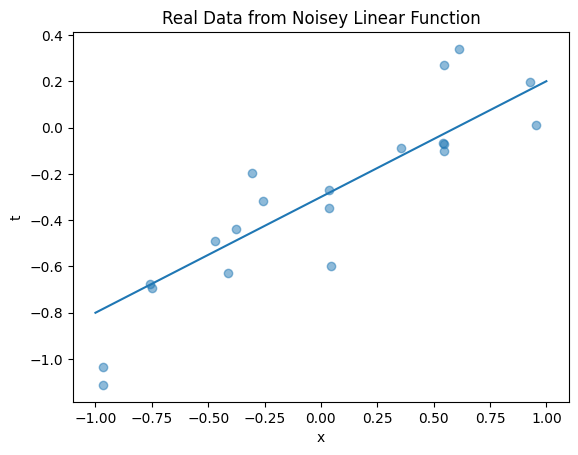

In [87]:
linbayes.make_scatter(X, y, real_parms = [a_0, a_1])

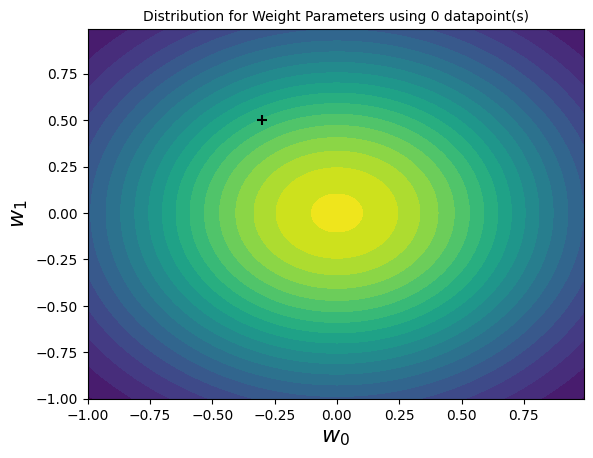

In [88]:
x_grid, y_grid = np.mgrid[-1:1:.01, -1:1:.01]
linbayes.make_contour(x_grid, y_grid, real_parms=[a_0, a_1], N=0)

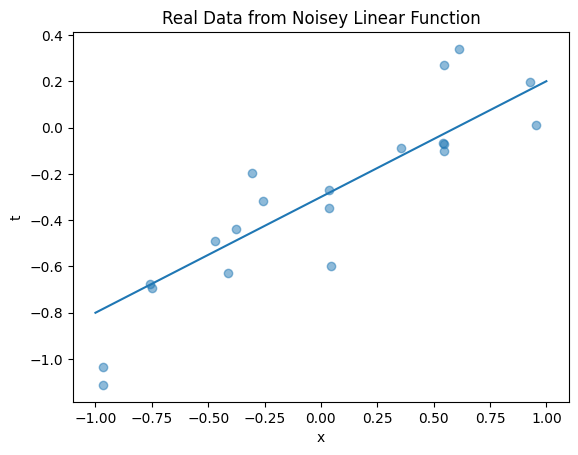

In [89]:
N=200
linbayes.make_scatter(X[0:N], y[0:N], real_parms=[a_0, a_1])

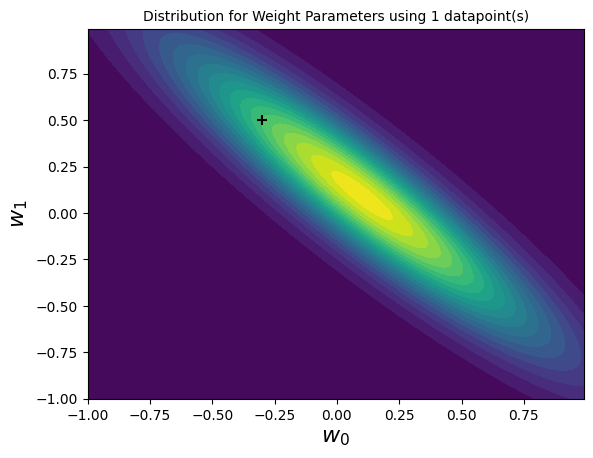

In [90]:
N=1
linbayes.set_posterior(X[0:N], y[0:N])
linbayes.make_contour(x_grid, y_grid, real_parms=[a_0, a_1], N=N)

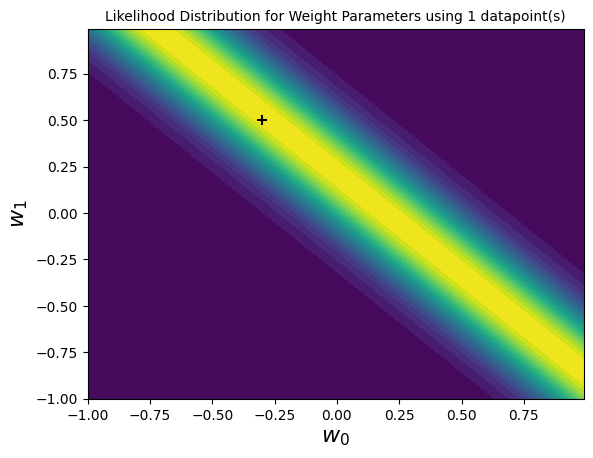

In [91]:
linbayes.set_likelihood(X[0:N], y[0:N], x_grid, y_grid)
linbayes.make_likelihood_contour(x_grid, y_grid, real_parms=[a_0, a_1], N=N)
